---
title: "Agglomerative Clustering"
author: "Vivek Sivaramakrishnan"
format:
  html:
    theme: theme.scss
    toc: true
    html-math-method: katex
---

Colab Link: [Click here!](https://colab.research.google.com/drive/18iOYqBoI7-FRUMOcv7G47PNBBxzSMeu2?usp=sharing){target="_blank"}

## Toy Dataset

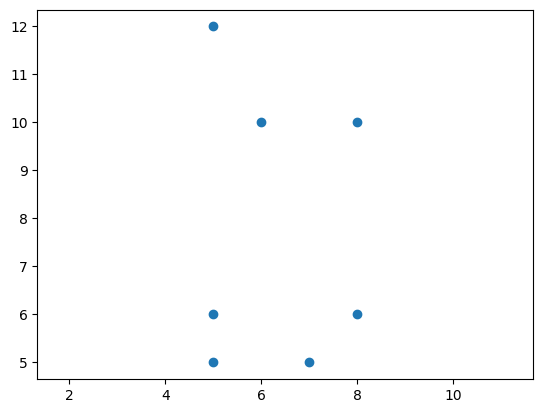

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

X = np.array([
    [5, 5], [5, 6],
    [7, 5], [8, 6],
    [6, 10], [5, 12], [8, 10]
])

plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

# Hierarchical Clustering

Generates hierarchical structures where the clusters formed at each stage are formed by combining clusters from the preceding stage. They are popularly represented using *dendrograms*.

Two strategies for Hierarchcical Clustering:
- **Agglomerative** (bottom-up): Start at the bottom and at each level recursively merge a selected pair of clusters into a single cluster. Candidate cluster-pair for merging will have smallest inter-group dissimilarity.
- **Divisive** (top-down): Start at the top and at each level recursively split one of the existing clusters at that level into two new clusters. Candidate cluster-split will result in largest betweein-group dissimilarity.

The measure of **dissimalarity** is governed by a *linkage* function. The linkage function will utilize a $n\times n$ pairwise dissimilarity matrix (in this notebook the distance between points is considered) to output cluster-dissimilarites, based on the type of linkage used.

Our main focus will be on examining the Agglomerative clustering approach, in conjunction with three linkage methods: Single, Complete, and Average.


**An application of Hierarchial Clustering!**

![jigsaw.png](https://i.ibb.co/NyyZ3RM/jigsaw.png)

## Agglomerative Clustering

The function `agglomerative` constructs a linkage matrix that encodes the hierarchical clustering, given a linkage function.

Mimics the behaviour of `scipy.cluster.hierarchy.linkage`

  Returns a $(n-1) \times 4$ matrix where:
  - 1st and 2nd elements denote the index of the merged clusters
  - 3rd element denotes the linkage value
  - 4th element denotes the number of values in the merged cluster
  
The above scaffolding is what is implemented in the scipy library, and we attempt to replicate it here.

This allows the usage of `scipy.cluster.hierarchy.dendrogram` to visualize the clustering.

In [ ]:
from itertools import combinations

def agglomerative(X, linkage):

  clusters = [[tuple(i)] for i in X]
  n = len(X)

  X_i = dict(zip([tuple(i) for i in X], range(n)))
  merged = []
  linkage_matrix = []
  Zs = []

  for _ in range(n-1):

    min_dist = np.inf
    current_clusters = [i for i in range(len(clusters)) if i not in merged]

    # Compute linkage for all clusters pairwise to find best cluster-pair
    for c1, c2 in combinations(current_clusters, 2):

      linkage_val = linkage(clusters[c1], clusters[c2])

      # Find cluster-pair with smallest linkage
      if linkage_val < min_dist:
        min_dist = linkage_val
        best_pair = sorted([c1, c2])

    # Merge the best pair and append to clusters
    clusters.append(clusters[best_pair[0]] + clusters[best_pair[1]])

    # Add best pair clusters to merged
    merged += best_pair

    linkage_matrix.append(best_pair + [min_dist, len(clusters[-1])])

    # Append cluster indicator array Z to Zs
    Z = np.zeros(n)
    for c in current_clusters:
      for i in clusters[c]:
        Z[X_i[i]] = c

    Zs.append(Z)

  Zs.append([len(clusters)-1]*n)

  return np.array(linkage_matrix), np.array(Zs)

### Linkage 1: Single Linkage
Considers the intergroup dissimilarity to be that of the closest (least dissimilar) pair. Also called the *nearest-neighbour* technique.

$$ d_{SL}(C_1, C_2) = \min _ {i \in C_1 \\ j \in C_2} d_{ij} $$
![](https://i.ibb.co/xjnP8v4/single-linkage-1.png])

In [ ]:
def single(cluster_1, cluster_2):
  single_linkage_val = np.inf

  for p1 in cluster_1:
    for p2 in cluster_2:

      p1_p2_dist = np.linalg.norm(np.array(p1)-np.array(p2))

      if single_linkage_val > p1_p2_dist:
        single_linkage_val = p1_p2_dist

  return single_linkage_val

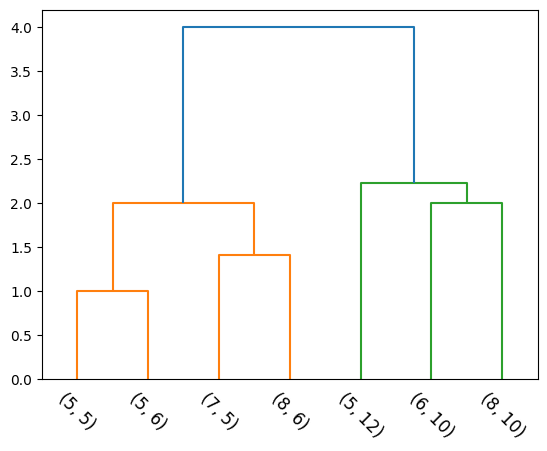

In [ ]:
l_mat, Zs = agglomerative(X, single)
dendrogram(l_mat, leaf_label_func=lambda i: str(tuple(X[i])), leaf_rotation=-45, color_threshold=3);

## Dendrograms - How to read them

Dendrograms provides a highly interpretable complete description of the hierarchical clustering in a graphical format.

The y-axis indicates the value of the inter-group dissimilarity. Cutting the dendrogram horizontally at a particular height partitions the data into disjoint clusters represented by the vertical lines that intersect it. These are the clusters that would be produced by terminating the procedure when the optimal intergroup dissimilarity exceeds that threshold cut value.

In [ ]:
def cluster_rename(Z):
  renamed_Z = []
  mapping = {}
  x = len(Z)

  for i in Z:
    try:
      renamed_Z.append(mapping[i])
    except:
      mapping[i] = x
      x -= 1
      renamed_Z.append(mapping[i])

  return renamed_Z

def plot_ellipse(X, ax):
  cov = np.cov(X[:, 0], X[:, 1])
  val, rot = np.linalg.eig(cov)
  val = np.sqrt(val)
  if min(val)<=0.01:
    val += 0.2 * max(val)
  center = np.mean([X[:, 0], X[:, 1]], axis=1)[:, None]

  t = np.linspace(0, 2.0 * np.pi, 1000)
  xy = np.stack((np.cos(t), np.sin(t)), axis=-1)

  return ax.plot(*(2 * rot @ (val * xy).T + center))

In [ ]:
from IPython.display import HTML
from matplotlib import animation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
dendrogram(l_mat, ax=ax2, leaf_label_func=lambda i: str(tuple(X[i])), leaf_rotation=-45);
artists = []
split_vals = list(l_mat[:, 2])
split_vals = np.array([0] + split_vals + [split_vals[-1]*1.05])

for i in range(len(Zs)):
  frame = []
  frame.append(ax1.scatter(X[:, 0], X[:, 1], c=cluster_rename(Zs[i]), s=500))
  for c in set(Zs[i]):
    if sum(Zs[i]==c) > 1:
      frame += plot_ellipse(X[Zs[i]==c], ax1)
  frame.append(ax2.axhline(y=split_vals[i:i+2].mean(), color='red'))
  artists.append(frame)

plt.close()

anim = animation.ArtistAnimation(fig, artists, interval=1000, repeat=False, blit=False);
HTML(anim.to_jshtml())

### Linkage 2: Complete Linkage
Considers the intergroup dissimilarity to be that of the furthest (most dissimilar) pair. Also called the *furthest-neighbour*, *Voorhees* technique.

$$ d_{CL}(C_1, C_2) = \max _ {i \in C_1 \\ j \in C_2} d_{ij} $$
![](https://i.ibb.co/FH9P2Lw/complete-linkage-1.png)

In [ ]:
def complete(cluster_1, cluster_2):
  complete_linkage_val = 0

  for p1 in cluster_1:
    for p2 in cluster_2:

      p1_p2_dist = np.linalg.norm(np.array(p1)-np.array(p2))

      if complete_linkage_val < p1_p2_dist:
        complete_linkage_val = p1_p2_dist

  return complete_linkage_val

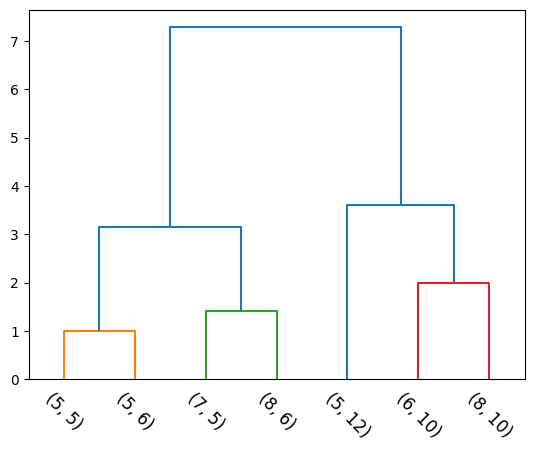

In [ ]:
l_mat, Zs = agglomerative(X, complete)
dendrogram(l_mat, leaf_label_func=lambda i: str(tuple(X[i])), leaf_rotation=-45, color_threshold=3);

Same clustering is achieved. Can you think about cases where the results would differ?

Let's try to investigate the difference between these linkage metrics, by constructing the following toy dataset:

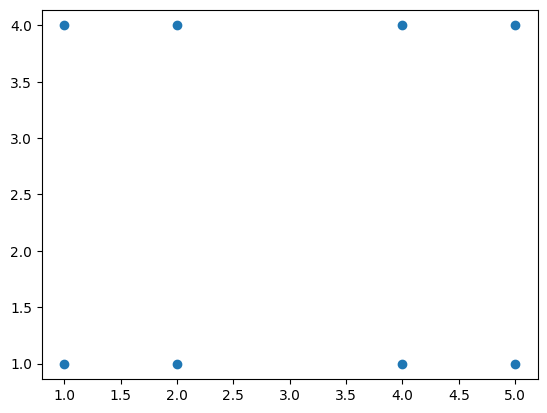

In [ ]:
X = np.array([
    [1, 1], [2, 1],
    [4, 1], [5, 1],
    [1, 4], [2, 4],
    [4, 4], [5, 4],
])

plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

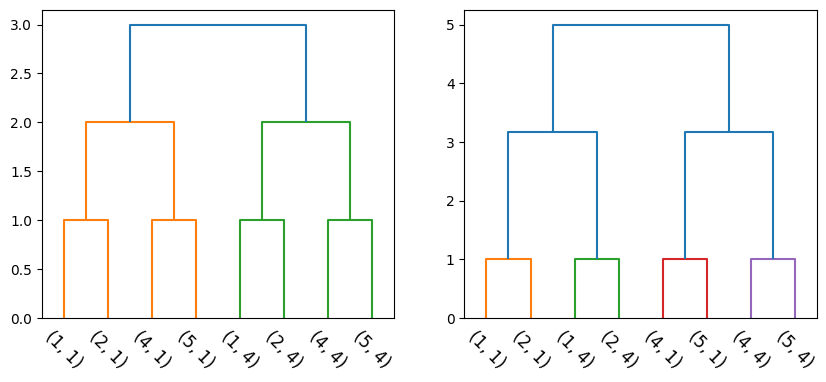

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
l_mat_1, Zs_1 = agglomerative(X, single)
dendrogram(l_mat_1, leaf_label_func=lambda i: str(tuple(X[i])), leaf_rotation=-45, color_threshold=3, ax=ax1);
l_mat_2, Zs_2 = agglomerative(X, complete)
dendrogram(l_mat_2, leaf_label_func=lambda i: str(tuple(X[i])), leaf_rotation=-45, color_threshold=3, ax=ax2);

Note that the above hierarchies are not equal (even though they seem to be, visually). The ordering of the singletons (X-axis) is not the same.

Let's take a look at how the clusters are formed at each time step:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
artists = []

for i in range(len(Zs_1)):
  frame = []
  frame.append(ax1.scatter(X[:, 0], X[:, 1], c=cluster_rename(Zs_1[i]), s=500))
  frame.append(ax2.scatter(X[:, 0], X[:, 1], c=cluster_rename(Zs_2[i]), s=500))

  for c in set(Zs_1[i]):
    if sum(Zs_1[i]==c) > 1:
      frame += plot_ellipse(X[Zs_1[i]==c], ax1)

  for c in set(Zs_2[i]):
    if sum(Zs_2[i]==c) > 1:
      frame += plot_ellipse(X[Zs_2[i]==c], ax2)

  artists.append(frame)

plt.close()

anim = animation.ArtistAnimation(fig, artists, interval=1000, repeat=False, blit=False);
HTML(anim.to_jshtml())

Observations:
- Single linkage has a tendence to combine observations linked by a series of close intermediate observations - *chaining*.
- Complete linkage tend to produce compact clusters with small diameters. (Can result in elements being close to members of other clusters than to their own)

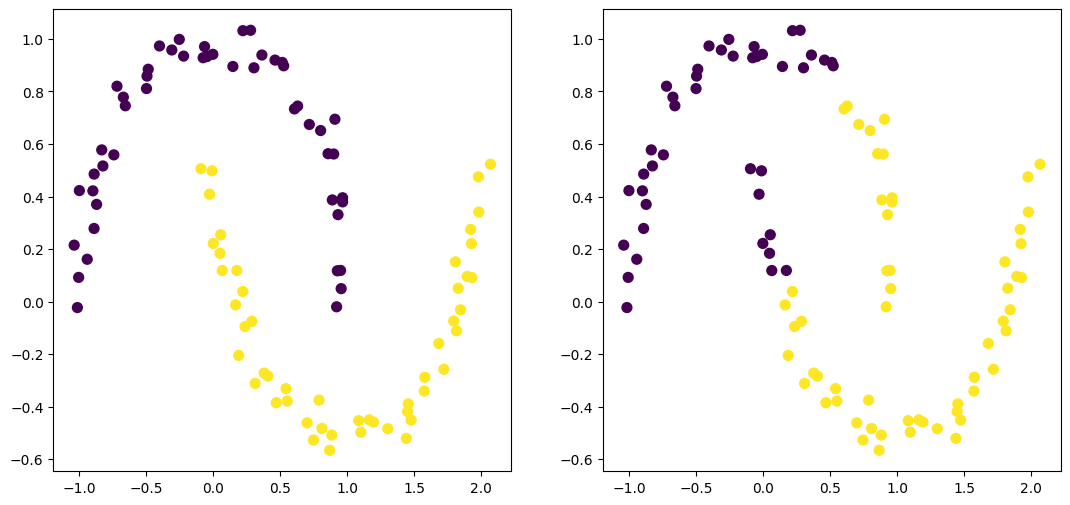

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=99, noise=0.05, random_state=170)

l_mat_1, Zs_1 = agglomerative(X, single)
l_mat_2, Zs_2 = agglomerative(X, complete)

# Plot (n-1)th timestep - 2 clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.scatter(X[:, 0], X[:, 1], c=cluster_rename(Zs_1[-2]), s=50)
ax2.scatter(X[:, 0], X[:, 1], c=cluster_rename(Zs_2[-2]), s=50)

### Linkage 3: Average Linkage
Considers the average dissimilarity between the groups

$$ d_{GA}(C_1, C_2) = \frac{1}{|C_1|*|C_2|}\sum _ {i \in C_1} \sum _ {j \in C_2} d_{ij} $$

![image.png](https://i.ibb.co/YLtW6sT/average-linkage-1.png)

In [ ]:
def average(cluster_1, cluster_2):
  average_linkage_val = 0

  for p1 in cluster_1:
    for p2 in cluster_2:

      p1_p2_dist = np.linalg.norm(np.array(p1)-np.array(p2))
      average_linkage_val += p1_p2_dist

  return average_linkage_val/(len(cluster_1)*len(cluster_2))

## Cluster-Maps

Hierarchical clustering also results in a partial ordering of our samples. This ordering can be investigated, when it is coupled along with a heat-map.

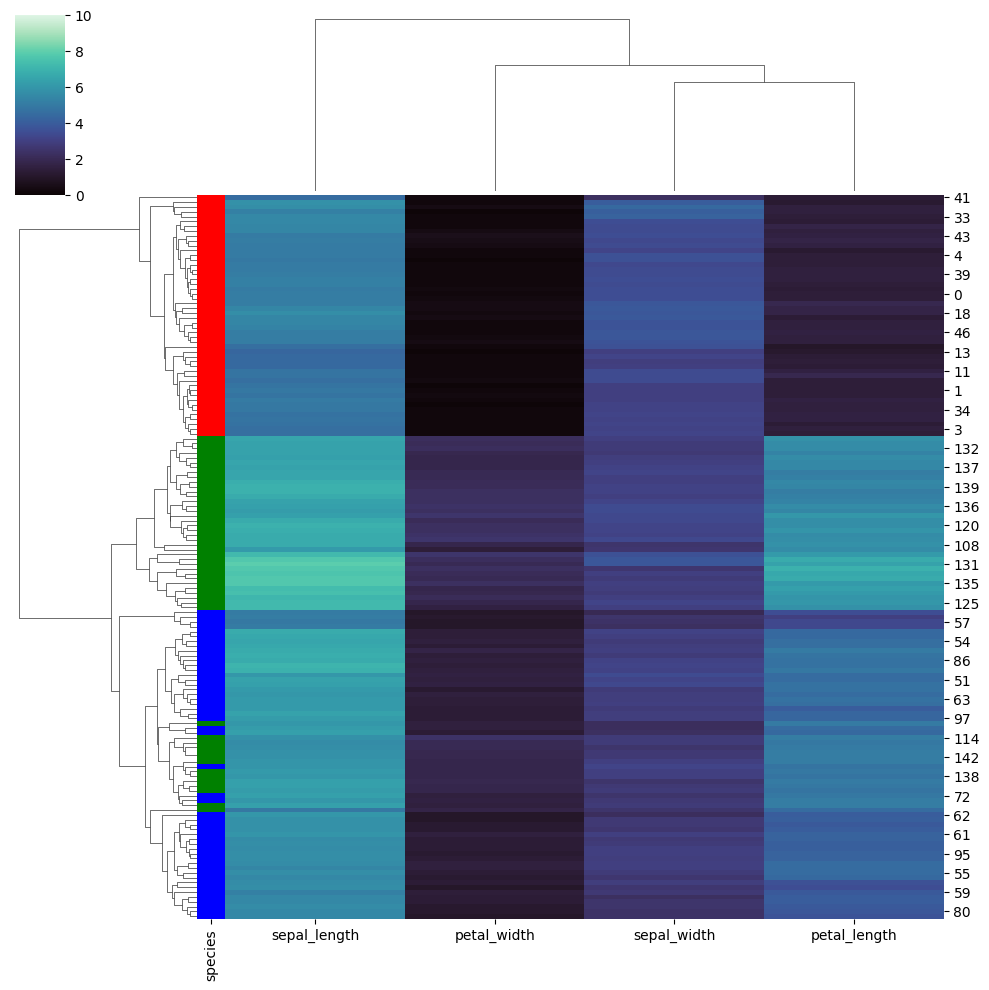

In [ ]:
import seaborn as sns

iris = sns.load_dataset("iris", cache=False)
species = iris.pop("species")

lut = dict(zip(species.unique(), "rbg"))
row_colors = species.map(lut)

sns.clustermap(iris, cmap="mako", vmin=0, vmax=10, row_colors=row_colors, method='average')